In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchgeometry as tgm
from torchvision import transforms
from PIL import Image

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl, get_params_from_rot_and_transl
from params_est import optim_step_ICP

from params_deepVO import par
from model_deepVO import DeepVO

In [28]:
ksize = 10
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4'
rgb_dir = '../data/synthetic/stylized-ww01-plane/blender_renders'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4/K_0.txt'

In [29]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [30]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [109]:
def load_data(depth_dir, rgb_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, rgb_all, RT_all, gt_depth_all = [], [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))[..., 0]
        img_as_img = Image.open(os.path.join(rgb_dir, f'{ind}.png'))
        img_as_tensor = transformer(img_as_img)[:3]
        if minus_point_5:
            img_as_tensor = img_as_tensor - 0.5  # from [0, 1] -> [-0.5, 0.5]
        img_as_tensor = normalizer(img_as_tensor)
        img_as_tensor = img_as_tensor.unsqueeze(0)
    
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        rgb_all.append(img_as_tensor)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    rgb_all = torch.cat(rgb_all, 0)
    RT_all = torch.tensor(np.stack(RT_all)).float()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, rgb_all, RT_all, gt_depth_all
    return depth_all, rgb_all, RT_all

In [110]:
def corrupt_depth(depth, sigma=0.1):
    mask = (depth != depth.max())
    depth_new = depth.clone()
    depth_new[mask] += (np.random.randn(*depth_new.shape) * sigma)[mask]
    return depth_new

In [111]:
depth, rgb_all, extr, gt_depth = load_data(gt_depth_dir, rgb_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

In [112]:
rgb_all.shape

torch.Size([2, 3, 608, 184])

In [92]:
depth[0].min(), depth[0].max()

(tensor(6.1420, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [93]:
gt_depth[0].min(), gt_depth[0].max()

(tensor(6.1641, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [94]:
depth[1].min(), depth[1].max()

(tensor(5.4822, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [95]:
depth.shape, gt_depth.shape

(torch.Size([2, 1080, 1920]), torch.Size([2, 1080, 1920]))

### Init deepVO model

In [96]:
load_model_path = par.load_model_path
M_deepvo = DeepVO(par.img_h, par.img_w, par.batch_norm)
use_cuda = torch.cuda.is_available()
if use_cuda:
    M_deepvo = M_deepvo.cuda()
    M_deepvo.load_state_dict(torch.load(load_model_path))
else:
    M_deepvo.load_state_dict(torch.load(load_model_path, map_location={'cuda:0': 'cpu'}))
print('Load model from: ', load_model_path)
M_deepvo.eval()

new_sizeize = (par.img_w, par.img_h)
img_mean = np.array(Image.open('../blender_renders/0.png'))[:, :, :3].reshape(-1, 3).mean(0) / 255
img_std = np.array(Image.open('../blender_renders/0.png'))[:, :, :3].reshape(-1, 3).std(0) / 255
normalizer = transforms.Normalize(mean=img_mean, std=img_std)
minus_point_5 = par.minus_point_5

transform_ops = []
resize_mode = 'crop'
if resize_mode == 'crop':
    transform_ops.append(transforms.CenterCrop((new_sizeize[0], new_sizeize[1])))
elif resize_mode == 'rescale':
    transform_ops.append(transforms.Resize((new_sizeize[0], new_sizeize[1])))
transform_ops.append(transforms.ToTensor())
transformer = transforms.Compose(transform_ops)

Load model from:  models/t000102050809_v04060710_im184x608_s5x7_b8_rnn1000_optAdagrad_lr0.0005.model.train


### Testing visualization

In [97]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

In [98]:
pc1.points

tensor([[ 0.5299, -0.3194,  6.3085],
        [ 0.5317, -0.3190,  6.3014],
        [ 0.5337, -0.3188,  6.2969],
        ...,
        [-0.1176,  0.8561,  6.6751],
        [-0.1154,  0.8578,  6.6884],
        [-0.1131,  0.8597,  6.7030]], dtype=torch.float64)

In [99]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [100]:
visualize_pcd(pc1)

### Testing params estimation (ICP correspondence set till convergence + LM till convergence)

In [113]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

TypeError: load_data() missing 1 required positional argument: 'gt_extrinsics_dir'

In [17]:
pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [18]:
visualize_pcd(pc0, pc1)

In [19]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

Correspondence set estimation...


KeyboardInterrupt: 

In [61]:
visualize_pcd(pc0, pc1)

In [62]:
transl

tensor([-1.8027,  0.0821, -0.0754], dtype=torch.float64)

In [63]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0272,  0.2619, -1.8027],
        [ 0.0305,  0.9995, -0.0084,  0.0821],
        [-0.2615,  0.0161,  0.9651, -0.0754],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [64]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### GradOdometry

In [114]:
depth, rgb, extr, gt_depth = load_data(gt_depth_dir, rgb_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = depth[1].clone()
_ = depth_first.requires_grad_()

In [115]:
_ = rgb.requires_grad_()
opt_rgb = optim.Adam([rgb], lr=1e-2)

In [116]:
img_first = depth[0].clone()
img_second = depth[1].clone()
_ = depth_first.requires_grad_()

In [117]:
depth_first.min(), depth_first.max()

(tensor(6.1425, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [45]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [46]:
gt_pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
gt_pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [47]:
# pc0.mask = gt_pc0.mask
# pc1.mask = gt_pc1.mask
# pc0.update_data(pc0.depth, pc0.intrinsic, pc0.extrinsic, update_mask=False)
# pc0.update_data(pc1.depth, pc1.intrinsic, pc1.extrinsic, update_mask=False)

In [48]:
visualize_pcd(pc0, pc1)

In [49]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [50]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [63]:
criterion = nn.MSELoss()

In [118]:
batch_predict_pose = M_deepvo.forward(rgb[None])
batch_predict_pose[0, 0, 5] = 0
rt_pr = tgm.angle_axis_to_rotation_matrix(batch_predict_pose[:, 0, :3])
rt_pr[0, :3, 3] = batch_predict_pose[0, 0, 3:]
opt_rgb.zero_grad()
loss = criterion(extr[0] @ rt_pr, extr[1])
loss

/Users/valeria/miniconda3/envs/robotics/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([1, 4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2703, grad_fn=<MseLossBackward>)

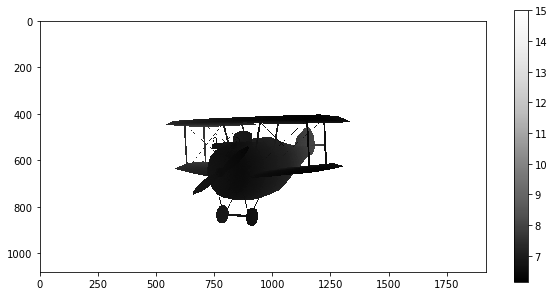

  0%|          | 0/30 [00:00<?, ?it/s]

L1 between depth_first pic with motion blur and GT: 0.000580654515090197
loss tensor(0.2703, grad_fn=<MseLossBackward>)


  0%|          | 0/30 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [121]:
gradslam_iter = 30
internal_iter = 5
opt = optim.Adam([depth_first], lr=1e-2)

depth_history = []
loss_history = []
internal_loss_history = []

depth_first_img = depth_first.cpu().data.numpy()
depth_first_img_gt = gt_depth[0].cpu().data.numpy()
depth_history.append(depth_first_img)
plt.figure(figsize=(10, 5))
plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.show()
print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))

for i in tqdm(range(gradslam_iter)):
    '''pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    T = torch.eye(4).double()
    for j in range(internal_iter):
        params_upd = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=1, verbose=0)
        transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
        rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
        pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)

        T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
        T = T_upd @ T
        rot, transl = T[:3, :3], T[:3, 3]
        params = get_params_from_rot_and_transl(rot, transl)
        # print('loss', loss_T(T, extr[0], extr[1]))
        loss_val = loss_params(params, extr[0], extr[1]).detach()
        internal_loss_history.append(loss_val.item())
        print('loss', loss_val)'''
    batch_predict_pose = M_deepvo.forward(rgb[None])
    batch_predict_pose[0, 0, 5] = 0
    rt_pr = tgm.angle_axis_to_rotation_matrix(batch_predict_pose[:, 0, :3])
    rt_pr[0, :3, 3] = batch_predict_pose[0, 0, 3:]
    opt_rgb.zero_grad()
    loss = criterion(extr[0] @ rt_pr, extr[1])
    loss_history.append(loss.item())
    print('loss', loss)
    loss.backward()
    opt_rgb.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    '''depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
    plt.colorbar()
    plt.show()
    print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))'''

In [72]:
depth_first.min(), depth_first.max()

(tensor(6.1311, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [73]:
depth_first_img_gt.min(), depth_first_img_gt.max()

(6.15234375, 15.0)

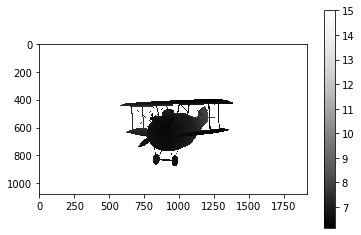

In [56]:
visualize_pcd(pc0, pc1)